In [25]:
# removes annoying deprecation warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
from google.cloud import bigquery
from bq_helper import BigQueryHelper #third party library to translate google query data to dataframe
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as fig_fact
import os
plotly.tools.set_config_file(world_readable=True, sharing='public')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, TheilSenRegressor

%matplotlib inline

with open('../key.txt') as f:
    content = f.readlines()

#add your own key here 
os.environ['GOOGLE_APPLICATION_CREDENTIALS']= content[0]

In [26]:
EPA_QUERY = """
        SELECT
            avg(arithmetic_mean) as am,
            CONCAT(cast(EXTRACT(YEAR FROM CO_daily.date_local) as string),
            cast(EXTRACT(MONTH FROM CO_daily.date_local) as string)) as year_month
        FROM
          `bigquery-public-data.epa_historical_air_quality.co_daily_summary` as CO_daily
        WHERE state_name ="California" AND city_name="San Francisco"
        GROUP BY year_month
        ORDER BY year_month DESC
        """

bq_assistant_CO = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_CO = bq_assistant_CO.query_to_pandas(EPA_QUERY)

In [27]:
df_CO.head()

,am,year_month
0,0.479866,20179
1,0.518230,20178
2,0.428956,20177
3,0.313639,20176
4,0.284872,20175


In [28]:
SF_CRIME_QUERY = """
        SELECT
          COUNT(*) as count,
          CONCAT(CAST(EXTRACT(YEAR
              FROM
                SFCrimeData.timestamp) AS string), CAST(EXTRACT(MONTH
              FROM
                SFCrimeData.timestamp) AS string)) AS year_month
        FROM
          `bigquery-public-data.san_francisco_sfpd_incidents.sfpd_incidents` AS SFCrimeData
        WHERE EXTRACT(YEAR FROM  SFCrimeData.timestamp) < 2014 AND category != "NON-CRIMINAL"
        GROUP BY
          year_month
        ORDER BY
          year_month DESC
        """
bq_assistant_SF_crime = BigQueryHelper("bigquery-public-data", "san_francisco_sfpd_incidents.sfpd_incidents")
df_SF_crime = bq_assistant_SF_crime.query_to_pandas(SF_CRIME_QUERY)

In [29]:
df_SF_crime.head(n=10)

,count,year_month
0,11885,20139
1,11757,20138
2,11132,20137
3,10536,20136
4,11064,20135
5,10776,20134
6,11147,20133
7,10156,20132
8,9828,201312
9,10523,201311


In [30]:
df_SF_census = pd.read_csv('../data/censuspopulationsf.tsv', sep='\t', header=None)
df_SF_census.columns = ['year', 'pop']
df_SF_census.head(n=20)

,year,pop
0,2003,757638
1,2004,750133
2,2005,748846
3,2006,751431
4,2007,758348
5,2008,767067
6,2009,774347
7,2010,805770
8,2011,816294
9,2012,830406


In [31]:
for i in range(len(df_SF_census)):
    df_SF_crime.loc[list((df_SF_crime[df_SF_crime['year_month'].str.contains(str(df_SF_census.loc[i,'year']))]).index.values), 'per_capita'] = df_SF_crime[df_SF_crime['year_month'].str.contains(str(df_SF_census.loc[i,'year']))]['count']/df_SF_census.loc[i,'pop']

In [32]:
df_SF_crime.head()

,count,year_month,per_capita
0,11885,20139,0.014127
1,11757,20138,0.013975
2,11132,20137,0.013232
3,10536,20136,0.012524
4,11064,20135,0.013152


In [47]:
df_merged = pd.merge(df_CO, df_SF_crime, on=['year_month'], left_index=True)
df_merged = df_merged.sort_values(by='am')
df_merged.head()

,am,year_month,count,per_capita
26,0.044623,20117,9370,0.011479
38,0.076163,20107,9766,0.012120
25,0.081365,20118,9780,0.011981
39,0.082974,20106,9656,0.011984
40,0.112227,20105,10378,0.012880


In [48]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

param_dist = {"n_estimators": [100, 125, 150, 175, 200, 225, 250, 275, 300],
              "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,None],
              "min_samples_split":  [2, 4, 6, 8, 10],
              "bootstrap": [True, False]}
search_regr=RandomForestRegressor(n_estimators= 100, random_state=42)
rf_random = RandomizedSearchCV(estimator = search_regr, param_distributions = param_dist, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(df_merged['am'].as_matrix().reshape(-1,1), df_merged['per_capita'].values)
rf_random.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/kristina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.4s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.4s
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.4s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True, total=   0.4s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=250, min_samples_split=2, max_d

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_merged['am'], df_merged['per_capita'].values, test_size=0.33, random_state=42)

rf_random.best_estimator_.fit(X_train.as_matrix().reshape(-1,1), y_train)

/home/kristina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [50]:
y_pred = rf_random.best_estimator_.predict(X_test.as_matrix().reshape(-1,1))

/home/kristina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [51]:
from sklearn import cross_validation
loo = cross_validation.LeaveOneOut(len(df_merged['per_capita'].values))
scores = cross_validation.cross_val_score(rf_random.best_estimator_, df_merged['am'].as_matrix().reshape(-1,1), df_merged['per_capita'].values, scoring='mean_squared_error', cv=loo,)

/home/kristina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [52]:
scores.mean()

-1.5948612432033276e-06

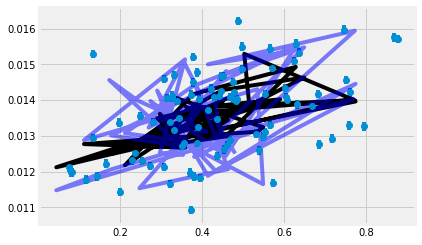

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.errorbar(X_train, y_train, 0.00012, fmt='o', alpha=1)
plt.plot(X_test, y_pred, '-k');
plt.plot(X_test, y_test, '-b', alpha=0.5);

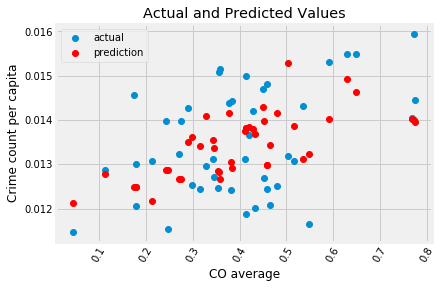

In [56]:
plt.plot(X_test, y_test, 'o', label = 'actual')
plt.plot(X_test, y_pred, 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('CO average'); plt.ylabel('Crime count per capita'); plt.title('Actual and Predicted Values');

In [58]:
df_merged.corr()

,am,count,per_capita
am,1.000000,0.329514,0.471756
count,0.329514,1.000000,0.889454
per_capita,0.471756,0.889454,1.000000


In [63]:
CRIMES = ['ARSON',
 'ASSAULT',
 'BAD CHECKS',
 'BRIBERY',
 'BURGLARY',
 'DISORDERLY CONDUCT',
 'DRIVING UNDER THE INFLUENCE',
 'DRUG/NARCOTIC',
 'DRUNKENNESS',
 'EMBEZZLEMENT',
 'EXTORTION',
 'FAMILY OFFENSES',
 'FORGERY/COUNTERFEITING',
 'FRAUD',
 'KIDNAPPING',
 'LARCENY/THEFT',
 'LIQUOR LAWS',
 'LOITERING',
 'NON-CRIMINAL',
 'OTHER OFFENSES',
 'PORNOGRAPHY/OBSCENE MAT',
 'PROSTITUTION',
 'RECOVERED VEHICLE',
 'ROBBERY',
 'RUNAWAY',
 'SECONDARY CODES',
 'SEX OFFENSES, FORCIBLE',
 'SEX OFFENSES, NON FORCIBLE',
 'STOLEN PROPERTY',
 'SUICIDE',
 'SUSPICIOUS OCC',
 'TRESPASS',
 'VANDALISM',
 'VEHICLE THEFT',
 'WARRANTS',
 'WEAPON LAWS']

In [77]:
SF_CRIME_QUERY = """
        SELECT
          COUNT(*) as count,
          CONCAT(CAST(EXTRACT(YEAR
              FROM
                SFCrimeData.timestamp) AS string), CAST(EXTRACT(MONTH
              FROM
                SFCrimeData.timestamp) AS string)) AS year_month
        FROM
          `bigquery-public-data.san_francisco_sfpd_incidents.sfpd_incidents` AS SFCrimeData
        WHERE EXTRACT(YEAR FROM  SFCrimeData.timestamp) < 2014 AND category = 
        GROUP BY
          year_month
        ORDER BY
          year_month DESC
        """
bq_assistant_SF_crime = BigQueryHelper("bigquery-public-data", "san_francisco_sfpd_incidents.sfpd_incidents")
df_SF_crime = bq_assistant_SF_crime.query_to_pandas(SF_CRIME_QUERY)

BadRequest: 400 Syntax error: Illegal input character "$" at [11:79]

SyntaxError: invalid syntax (<ipython-input-78-295e77664761>, line 1)